## Import Necessary Packages

In [1]:
import numpy as np
from pytope import Polytope
import matplotlib.pyplot as plt
import time
import scipy.io as scio

from Planner_P import Planner_P
from ModelingSV import ModelingSV

%matplotlib inline

## General Parameters

In [2]:
T         = 0.25 # time interval
N         = 8    # prediction horizon
N_set     = 4    # number of reachable set -- coarse
T_set     = T*N/N_set # time interval for computating the set -- coarse
infinity  = 1000000   # infinity
max_speed = 50  # max speed, m/s
l_veh     = 4.3 # vehicle length
w_veh     = 1.8 # vehicle width
DEV       = 5   # dimenstion of EV
DPM       = 6   # diemnsion of EV in the point mass
DSV       = 2   # dimenstion of SV
w_lane    = 4   # lane width
L_Bound   = [0, w_lane, 2*w_lane]  # lane boundary
L_Center  = [w_lane/2, 1.5*w_lane] # lane center
N_Lane    = 2 # lane number
N_Car     = 2 # car number

# Following is to load the distribution of control actions of SV -- from a dataset
cdf_x = scio.loadmat('cdf_x.mat')
cdf_f = scio.loadmat('cdf_f.mat')
cdf_x = cdf_x['cdf_x'] # samples of acceleration
cdf_f = cdf_f['cdf_f'] # cdf probability

# Following define the SV in the EV controller
A_SV = np.array([[1, T], [0, 1]]) # A matrix of SV model
B_SV = np.array([T**2/2, T]) # B matrix of SV model
A_SV_set = np.array([[1, T_set], [0, 1]])
B_SV_set = np.array([T_set**2/2, T_set])
low_bound_state_sv = (-infinity, 0)
up_bound_state_sv  = (infinity, max_speed)
X_SV_Poly          = Polytope(lb = low_bound_state_sv, ub = up_bound_state_sv)
low_bound_ax  = -6.63
up_bound_ax   = 2.73
con_level     = 0.01

## Define Parameter Set for EV and SV Controllers

In [3]:
opts_Parameters_SV = {    
    'N': N,
    'w_lane': w_lane,
    'max_speed': max_speed,
    'T': T,
    'DSV': DSV,
    'cdf_x': cdf_x,
    'cdf_f': cdf_f,
    'con_level': con_level}

opts_Parameters_EV = { 
    'T': T,     
    'N': N,
    'N_set': N_set,
    'T_set': T_set,
    'w_lane': w_lane,
    'l_veh': l_veh,
    'w_veh': w_veh,
    'l_f': 1.65,
    'l_r': 1.65,
    'DEV': DEV,
    'DPM': DPM,
    'A_SV': A_SV,
    'B_SV': B_SV,
    'A_SV_set': A_SV_set,
    'B_SV_set': B_SV_set,
    'X_SV_Poly': X_SV_Poly,
    'infinity': infinity,
    'low_bound_ax': low_bound_ax,
    'up_bound_ax': up_bound_ax,
    'max_speed': max_speed,
    'v_ref': 35, # reference speed
    'Q1': 10,  # steering wheel angle
    'Q2': 0.1, # longitudinal jerk
    'Q3': 0.1, # lateral error
    'Q4': 1,   # long. error
    'Q5': 10   # heading error
}

## Motion Planning

In [4]:
MotionPlanner_P = Planner_P(Params = opts_Parameters_EV)
ModelingSV      = ModelingSV(Params = opts_Parameters_SV)

In [5]:
K_P = 100

# SV
x_SV_0 = np.array([200, 15]) # initial state of SV: x, v
u_SV_0 = 0                   # initial control of SV -- long. acceleration
X_SV_State = list( ) # x and v
Y_SV_State = list( ) # y
U_SV          = list( ) # a_x
X_SV_Planning = list( ) # SV planning trajectory x and v in the horizon
Y_SV_Planning = list( ) # SV's planning trajectory y in the horizon
X_SV_State.append(x_SV_0)
Y_SV_State.append(w_lane/2)
U_SV.append(u_SV_0)

# EV
x_EV_0 = np.array([0, w_lane/2, 0, 30, 0]) # initial state of EV: x, y phi, v
X_EV_Planning = list( )
X_EV_State    = list( )
U_EV = list( )
X_EV_State.append(x_EV_0)
Robust_SV = list( ) # tube of SV in the prediction horizon

samples = np.array([-0.01, 0, 0.01])
Low_Bound = list( )
Up_Bound  = list( )

In [6]:
for k in range(K_P + 1):
    
    print('the step is', k)
    
    control_SV_horizon_k, x_SV_planning_k, y_SV_planning_k = ModelingSV.Return(k, U_SV[k], X_SV_State[k])

    U_k, trajectory_planning_k, Robust_SV_k, low_ax, up_ax = MotionPlanner_P.Return(X_SV_State[k], Y_SV_State[k], X_EV_State[k], samples)
   
    X_SV_State.append(x_SV_planning_k[:, 1])
    Y_SV_State.append(y_SV_planning_k[1])
    U_SV.append(control_SV_horizon_k[0][0])
    X_SV_Planning.append(x_SV_planning_k)
    Y_SV_Planning.append(y_SV_planning_k)
    
    X_EV_Planning.append(trajectory_planning_k)
    X_EV_State.append(trajectory_planning_k[:, 1])
    U_EV.append(U_k)
    Robust_SV.append(Robust_SV_k)

    Low_Bound.append(low_ax)
    Up_Bound.append(up_ax)
    
    samples = np.append(samples, U_SV[k]) # update the sampling
print('Done')
t = np.arange(0, T*(K_P + 1), T, dtype=float)

the step is 0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

the step is 1
the step is 2
the step is 3
the step is 4
the step is 5
the step is 6
the step is 7
the step is 8
the step is 9
the step is 10
the step is 11
the step is 12
the step is 13
the step is 14
the step is 15
the step is 16
the step is 17
the step is 18
the step is 19
the step is 20
the step is 21
the step is 22
the step is 23
the step is 24
the step is 25
the step is 26
the step is 27
the step is 28
the step is 29
the step is 30
the step is 31
the step is 32
the step is 33
the step is 34
the step is 35
the step is 36
the step is 37
the step is 38
the step is 39
the step is 40
the step

## Show Global Paths

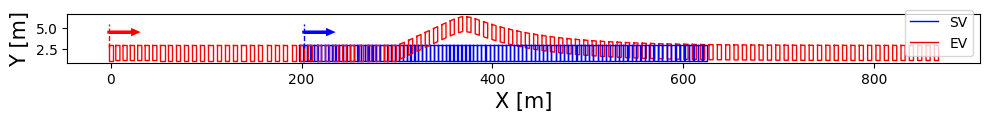

In [7]:
def rota_rect_ev(state, l, w):
    # Note: the first four states must be x, y, heading, velocity
    
    x       = state[0]
    y       = state[1]
    box     = [(x - l/2, y + w/2), (x + l/2, y + w/2), (x + l/2, y - w/2), (x - l/2, y - w/2)]
    heading = state[2]
    
    box_matrix = np.array(box) - np.repeat(np.array([[x, y]]), len(box), 0)
    theta = -heading
    rota_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

    new = box_matrix.dot(rota_matrix) + np.repeat(np.array([[x, y]]), len(box), 0)
    
    x = [new[0][0], new[1][0], new[2][0], new[3][0], new[0][0]]
    y = [new[0][1], new[1][1], new[2][1], new[3][1], new[0][1]]
    return x, y

def rota_rect_sv(state, l, w):
    # Note: the first four states must be x, y, heading, velocity
    
    x       = state[0]
    y       = w_lane/2
    box     = [(x - l/2, y + w/2), (x + l/2, y + w/2), (x + l/2, y - w/2), (x - l/2, y - w/2)]
    heading = 0
    
    box_matrix = np.array(box) - np.repeat(np.array([[x, y]]), len(box), 0)
    theta = -heading
    rota_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

    new = box_matrix.dot(rota_matrix) + np.repeat(np.array([[x, y]]), len(box), 0)
    
    x = [new[0][0], new[1][0], new[2][0], new[3][0], new[0][0]]
    y = [new[0][1], new[1][1], new[2][1], new[3][1], new[0][1]]
    return x, y

plt.figure(figsize=(10, 1.3), tight_layout=True)
for k in range(len(t)):
    x_SV, y_SV = rota_rect_sv(X_SV_State[k], l_veh, w_veh)
    x_EV, y_EV = rota_rect_ev(X_EV_State[k], l_veh, w_veh)

    plt.plot(x_SV, y_SV, c='b', linewidth=1, label='SV' if k == 0 else "")
    plt.plot(x_EV, y_EV, c='r', linewidth=1, label='EV' if k == 0 else "")

plt.axvline(x = 0 - l_veh/2, ymin = 0.3, ymax = 0.8, color='red', linestyle='--', linewidth = 1)  # Adjust ymin and ymax based on axis limits
plt.arrow(0 - l_veh/2, 4.5, 30, 0, color='red', head_width = 0.5, head_length = 5, linewidth = 2, length_includes_head = True)

plt.axvline(x = 200 + l_veh/2, ymin = 0.3, ymax  = 0.8, color = 'blue', linestyle = '--', linewidth = 1)  # Adjust ymin and ymax based on axis limits
plt.arrow(200 + l_veh/2, 4.5, 30, 0, color = 'blue', head_width = 0.5, head_length = 5, linewidth = 2, length_includes_head = True)

plt.xlabel("X [m]", fontsize=15)
plt.ylabel("Y [m]", fontsize=15)
plt.legend()